In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import json

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import seaborn as sn
from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [3]:
data = pd.read_csv("datasets/19/IMDB Dataset.csv")
data.shape

(50000, 2)

# Express EDA

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [6]:
# Распределение классов
data.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

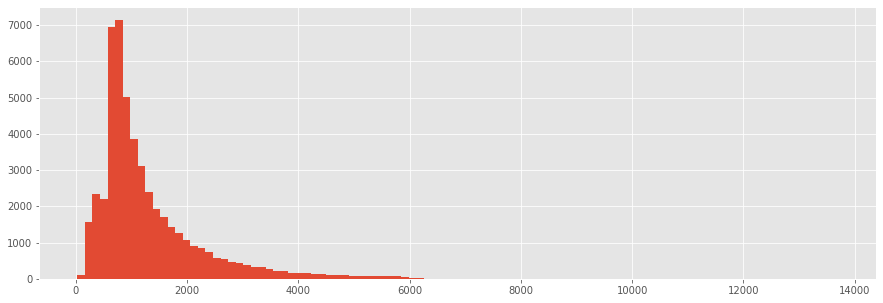

In [7]:
# Добавляем признак, количество символов в одной комментарии 

text_size = []
for i, r in data.iterrows():
    text_size.append(len(r["review"]))

    
data["text_size"] =  text_size       

plt.figure(figsize=(15,5))
data.text_size.hist(bins=101)
plt.show()

In [8]:
# Имеются очень длинные тексты, смотрим на несколь из них
data[data.text_size>6000][['review']].values[1]

array(['Warning: Does contain spoilers.<br /><br />Open Your Eyes<br /><br />If you have not seen this film and plan on doing so, just stop reading here and take my word for it. You have to see this film. I have seen it four times so far and I still haven\'t made up my mind as to what exactly happened in the film. That is all I am going to say because if you have not seen this film, then stop reading right now.<br /><br />If you are still reading then I am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think.<br /><br />I remember my Grade 11 English teacher quite well. His name was Mr. Krisak. To me, he was wise beyond his years and he always had this circuitous way of teaching you things that perhaps you weren\'t all too keen on. If we didn\'t like Shakespeare, then he turned the story into a modern day romance with modern day language so we could understand it. Our class room was never a room, it was a cottage and we

In [9]:
# Вроде выглядит норм, как нормальный коммент. Только нужно удалить html теги

In [10]:
import re

def tag_remover(raw_html):
    remover = re.compile('<.*?>')
    cleantext = re.sub(remover, '', raw_html)
    return cleantext

In [11]:
reviews_clean = []
for i, r in data.iterrows():
    text = tag_remover(r["review"])
    reviews_clean.append(text)

data["review"] = reviews_clean

In [12]:
data.head()

,review,sentiment,text_size
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. The filming tec...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


# ML

In [14]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shokan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [16]:
data.review = data.review.apply(lambda x: data_Stemmer(x))

In [17]:
X = data.review
y = data.sentiment

In [18]:
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.01, norm=None)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)
X_train_tf.shape, X_test_tf.shape

((35000, 1738), (15000, 1738))

In [21]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=5, 
    max_iter=500, 
    penalty='l2', 
    random_state=42
)

In [23]:
logit_sgd.fit(X_train_tf, y_train)

print(accuracy_score(logit_sgd.predict(X_train_tf), y_train))
print(accuracy_score(logit_sgd.predict(X_test_tf), y_test))

print(classification_report(logit_sgd.predict(X_test_tf), y_test))

0.8646285714285714
0.8440666666666666
              precision    recall  f1-score   support

    negative       0.87      0.83      0.85      7760
    positive       0.82      0.86      0.84      7240

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000



In [24]:
top_positives = pd.DataFrame(logit_sgd.coef_, columns=tf_vectorizer.get_feature_names(
)).T.sort_values(by=0, ascending=False).reset_index().head(20)
top_positives.columns = ["features", "coeff"]
top_positives.head()

top_negatives = pd.DataFrame(logit_sgd.coef_, columns=tf_vectorizer.get_feature_names(
)).T.sort_values(by=0, ascending=True).reset_index().head(20)
top_negatives.columns = ["features", "coeff"]
top_negatives.head()

,features,coeff
0,awful,-0.586092
1,wast,-0.519601
2,one worst,-0.435586
3,worst,-0.430857
4,terrible,-0.383883


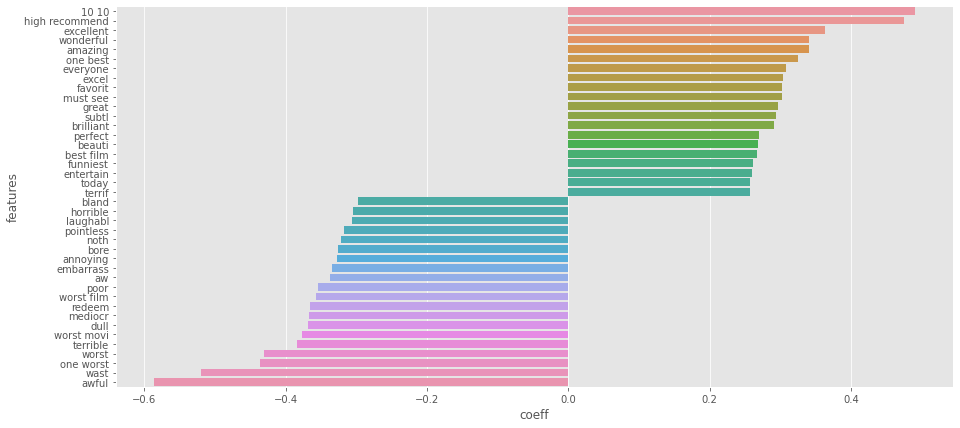

In [25]:
df = pd.concat([top_positives, top_negatives]).sort_values(by="coeff", ascending=False)
plt.figure(figsize=(15,7))
sns.barplot(data=df, x="coeff", y="features")
plt.show()